In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import matplotlib.style as style
style.use('seaborn-whitegrid')

import os
import re
# import googlemaps
# import time
import pickle
from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TreebankWordTokenizer, wordpunct_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.util import ngrams
from nltk.corpus import stopwords

from textblob import TextBlob

import string



In [4]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [3]:
# Set pandas options
pd.set_option('max_rows', 10)
# pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

*Load the relevant data file*

In [153]:
# df = pd.read_csv('data/cleaned_reviews.csv')

# df = pd.read_csv('data/listing_descriptions.csv', index_col=0)
df = pd.read_csv('data/cleaned_df.csv', index_col='Unnamed: 0')

df2 = pd.read_csv('data/df_with_lda.csv', index_col='Unnamed: 0')

In [11]:
df.head(2)

,id,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,...,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02
1,12899,49682,1,1,Concordia,97211,45.564010,-122.634717,Guest suite,Private room,...,497,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4.69


#### Using RegEx to grab individual amenities, and ultimately one-hot encode relevant ones

In [43]:
[x for x in re.findall('[^{},"]*', z) if x !='']

['TV',
 'Wifi',
 'Kitchen',
 'Free parking on premises',
 'Indoor fireplace',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Fire extinguisher']

In [48]:
df['amenities'] = df['amenities'].apply(lambda z: [x for x in re.findall('[^{},"]*', z) if x !=''])

In [76]:
# Get all of the amenities into a dictionary, and sort by frequency
counts = defaultdict(int)

for i in range(5044):
    for amenity in df['amenities'][i]:
        counts[amenity] += 1

sorted(counts.items(), reverse=True, key=lambda tup: tup[1])

[('Wifi', 4971),
 ('Essentials', 4924),
 ('Heating', 4906),
 ('Smoke detector', 4848),
 ('Shampoo', 4395),
 ('Kitchen', 4368),
 ('Hangers', 4361),
 ('Carbon monoxide detector', 4350),
 ('Hair dryer', 4120),
 ('Laptop friendly workspace', 3961),
 ('Iron', 3885),
 ('Fire extinguisher', 3730),
 ('TV', 3615),
 ('Washer', 3518),
 ('Dryer', 3515),
 ('Hot water', 3434),
 ('First aid kit', 2948),
 ('Self check-in', 2909),
 ('Air conditioning', 2839),
 ('Free street parking', 2797),
 ('Family/kid friendly', 2645),
 ('Free parking on premises', 2556),
 ('Refrigerator', 2296),
 ('Dishes and silverware', 2213),
 ('Private entrance', 2103),
 ('Bed linens', 2082),
 ('Coffee maker', 2059),
 ('Microwave', 1956),
 ('Internet', 1906),
 ('Cooking basics', 1842),
 ('Stove', 1781),
 ('Extra pillows and blankets', 1770),
 ('Oven', 1706),
 ('Luggage dropoff allowed', 1596),
 ('Lock on bedroom door', 1490),
 ('Long term stays allowed', 1422),
 ('Dishwasher', 1364),
 ('Garden or backyard', 1342),
 ('Indoor fir

In [101]:
# Use regex and for loop to make syntax of one-hot encoding easier :)
for x in ['Gym', 'Kitchen', 'Pets allowed', 'Hot tub',
          'Washer', 'Refrigerator', 'Air conditioning',
          'Family/kid friendly', 'Private entrance',
          'Indoor fireplace', 'Patio or balcony',
          'Cable TV', '24-hour check-in', 'Bathtub']:
    print(f"df['amenities_{x.lower().replace(' ', '_').replace('/', '_').replace('-', '_')}'] = df['amenities'].apply(lambda x: 1 if '{x}' in set(x) else 0)")

df['amenities_gym'] = df['amenities'].apply(lambda x: 1 if 'Gym' in set(x) else 0)
df['amenities_kitchen'] = df['amenities'].apply(lambda x: 1 if 'Kitchen' in set(x) else 0)
df['amenities_pets_allowed'] = df['amenities'].apply(lambda x: 1 if 'Pets allowed' in set(x) else 0)
df['amenities_hot_tub'] = df['amenities'].apply(lambda x: 1 if 'Hot tub' in set(x) else 0)
df['amenities_washer'] = df['amenities'].apply(lambda x: 1 if 'Washer' in set(x) else 0)
df['amenities_refrigerator'] = df['amenities'].apply(lambda x: 1 if 'Refrigerator' in set(x) else 0)
df['amenities_air_conditioning'] = df['amenities'].apply(lambda x: 1 if 'Air conditioning' in set(x) else 0)
df['amenities_family_kid_friendly'] = df['amenities'].apply(lambda x: 1 if 'Family/kid friendly' in set(x) else 0)
df['amenities_private_entrance'] = df['amenities'].apply(lambda x: 1 if 'Private entrance' in set(x) else 0)
df['amenities_indoor_fireplace'] = df['amenities'].apply(lambda x: 1 if 'Indoor fireplace' in set(x) else 0)
df

In [30]:
# One hot encode all of the relevant amenities
df['amenities_gym'] = df['amenities'].apply(lambda x: 1 if 'Gym' in set(x) else 0)
df['amenities_kitchen'] = df['amenities'].apply(lambda x: 1 if 'Kitchen' in set(x) else 0)
df['amenities_pets_allowed'] = df['amenities'].apply(lambda x: 1 if 'Pets allowed' in set(x) else 0)
df['amenities_hot_tub'] = df['amenities'].apply(lambda x: 1 if 'Hot tub' in set(x) else 0)
df['amenities_washer'] = df['amenities'].apply(lambda x: 1 if 'Washer' in set(x) else 0)
df['amenities_refrigerator'] = df['amenities'].apply(lambda x: 1 if 'Refrigerator' in set(x) else 0)
df['amenities_air_conditioning'] = df['amenities'].apply(lambda x: 1 if 'Air conditioning' in set(x) else 0)
df['amenities_family_kid_friendly'] = df['amenities'].apply(lambda x: 1 if 'Family/kid friendly' in set(x) else 0)
df['amenities_private_entrance'] = df['amenities'].apply(lambda x: 1 if 'Private entrance' in set(x) else 0)
df['amenities_indoor_fireplace'] = df['amenities'].apply(lambda x: 1 if 'Indoor fireplace' in set(x) else 0)
df['amenities_patio_or_balcony'] = df['amenities'].apply(lambda x: 1 if 'Patio or balcony' in set(x) else 0)
df['amenities_cable_tv'] = df['amenities'].apply(lambda x: 1 if 'Cable TV' in set(x) else 0)
df['amenities_24_hour_check_in'] = df['amenities'].apply(lambda x: 1 if '24-hour check-in' in set(x) else 0)
df['amenities_bathtub'] = df['amenities'].apply(lambda x: 1 if 'Bathtub' in set(x) else 0)

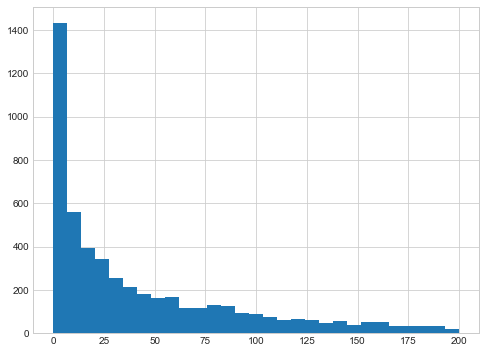

In [127]:
plt.figure(figsize=(8,6))
plt.hist(df['number_of_reviews'], bins='auto', range=(0,200), align=');

In [118]:
df['review_scores_rating'].value_counts()

100.0    1258
99.0      857
98.0      773
97.0      530
96.0      399
95.0      260
94.0      175
93.0      163
90.0      105
92.0       89
91.0       61
80.0       41
89.0       35
88.0       32
87.0       24
         ... 
83.0        8
84.0        7
81.0        6
82.0        6
73.0        5
77.0        3
70.0        3
67.0        1
40.0        1
20.0        1
78.0        1
76.0        1
68.0        1
55.0        1
79.0        1
Name: review_scores_rating, Length: 33, dtype: int64

#### Merge dataframe of listings info (df) with dataframe of reviews info (df2)

In [154]:
df3 = df.merge(df2, how='inner', left_on='id', right_on='listing_id')

In [312]:
df3.tail()

,id_x,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7
318257,28812036,217086646,1,1,South Portland,97239,45.498897,-122.680050,Condominium,Entire home/apt,5,1.5,2.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",79,1,2,90.0,10.0,7.0,10.0,10.0,10.0,9.0,1,2.0,28812036,330598649,2018-09-30,105408229,Kathleen,"Moda Center. As a new host to air bnb, Doug wa...",moda center host doug quick commun recept sugg...,0.183838,0.448906,206,moda center host doug quick communication rece...,3,moda center as a new host to air bnb doug was ...,"['moda', 'center', 'as', 'a', 'new', 'host', '...",41,3.902439,"[('quick', 2), ('place', 2)]",0.012507,0.012509,0.206340,0.012500,0.012508,0.693623,0.012509,0.012501,0.012501,0.012502,0,0,0,0,0,1,0
318258,28812036,217086646,1,1,South Portland,97239,45.498897,-122.680050,Condominium,Entire home/apt,5,1.5,2.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",79,1,2,90.0,10.0,7.0,10.0,10.0,10.0,9.0,1,2.0,28812036,333799631,2018-10-07,217078455,Jorge,Feel at home in this cozy apartment with a gre...,feel home cozi apart great view,0.300000,0.750000,54,feel home cozy apartment great view,1,feel at home in this cozy apartment with a gre...,"['feel', 'at', 'home', 'in', 'this', 'cozy', '...",11,3.909091,[],0.016669,0.388173,0.016671,0.016668,0.478445,0.016675,0.016675,0.016672,0.016676,0.016676,1,0,0,0,0,0,0
318259,28866190,217508696,1,1,South Portland,97219,45.473536,-122.679010,Guest suite,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",""Free parking on p...",69,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,28866190,330516667,2018-09-30,34245803,Harshit,We had a great experience. The house has all t...,great experi hous amen requir clean everyth li...,0.478889,0.733333,176,great experience house amenities required clea...,5,we had a great experience the house has all th...,"['we', 'had', 'a', 'great', 'experience', 'the...",31,4.516129,[],0.539725,0.009092,0.009091,0.009091,0.009092,0.009092,0.009091,0.387541,0.009092,0.009092,0,0,0,0,0,0,0
318260,28993289,186186834,3,3,Lents,97266,45.477691,-122.568251,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",He...",150,4,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,28993289,333748311,2018-10-07,164222226,Dennis,Thank you for hosting and I appreciate the goo...,thank host appreci good commun highli recommend,0.517500,0.570000,83,thank hosting appreciate good communication hi...,2,thank you for hosting and i appreciate the goo...,"['thank', 'you', 'for', 'hosting', 'and', 'i',...",13,5.230769,[],0.014291,0.014292,0.014286,0.014287,0.014292,0.437785,0.014287,0.447906,0.014287,0.014287,0,0,0,0,0,1,0
318261,29051346,99130184,1,1,Mt. Tabor,97215,45.508009,-122.603037,Guest suite,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Pets allowed"",Heating,Washer...",73,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,29051346,334328607,2018-10-08,1846976,Jodi,Ellie's place was terrific. Everything is new ...,elli place terrif everyth comfort live room di...,0.306882,0.697263,801,ellies place terrific everything comfortable l...,12,ellies place was terrific everything is new an...,"['ellies', 'place', 'was', 'terrific', 'ever

In [4]:
# df3.to_csv('final_full_df.csv')
df3 = pd.read_csv('final_full_df.csv', index_col='Unnamed: 0')

/Users/brenner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df3.dtypes

id_x                           int64
host_id                        int64
host_listings_count            int64
host_total_listings_count      int64
neighbourhood                 object
zipcode                       object
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
                              ...   
individual_words              object
word_count                     int64
average_word_length          float64
most_frequent_words           object
cluster_pred                   int64
lda_1                        float64
lda_2                        float64
lda_3                        float64
lda_4                        float64
lda_5                        float64
lda_6                        float64
l

In [6]:
df3 = pd.get_dummies(df3, columns=['cluster_pred'], drop_first=False)

In [15]:
df3 = pd.get_dummies(df3, columns=['neighbourhood', 'property_type'], drop_first=False)

In [21]:
df3 = pd.get_dummies(df3, columns=['room_type'], drop_first=False)

In [23]:
df3 = pd.get_dummies(df3, columns=['bed_type'], drop_first=False)

In [16]:
df3 = df3.dropna(axis=0)

In [31]:
df3.columns.values

array(['id_x', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'zipcode', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities',
       'price', 'guests_included', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'listing_id', 'id_y', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences',
       'comment_words_only', 'individual_words', 'word_count',
       'average_word_length', 'most_frequent_words', 'lda_1', 'lda_2',
       'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2',
       'cluster_pred_3', '

In [ ]:
df3.

In [298]:
df3.describe()

,id_x,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,reviewer_id,polarity,subjectivity,review_length,num_sentences,word_count,average_word_length,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7
count,3.055740e+05,3.055740e+05,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,3.055740e+05,3.055740e+05,3.055740e+05,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000
mean,9.763483e+06,2.795592e+07,4.734644,4.734644,45.529374,-122.647990,3.164477,1.148925,1.148278,1.713457,100.388511,1.855681,169.917686,97.199755,9.935881,9.865911,9.984400,9.976379,9.842123,9.823496,0.477969,4.898857,9.763483e+06,1.711244e+08,5.462425e+07,0.423587,0.640812,294.588476,4.395325,52.845501,4.539532,0.114813,0.106284,0.096228,0.044418,0.129837,0.133989,0.084443,0.059822,0.132582,0.097583,0.133470,0.155085,0.119519,0.119830,0.104309,0.126866,0.118367
std,7.127360e+06,3.727847e+07,54.913803,54.913803,0.030653,0.040688,1.584140,0.685585,0.736991,1.080173,196.337102,1.106612,127.167931,2.519818,0.259332,0.368355,0.134728,0.165913,0.370776,0.395109,0.499515,2.657622,7.127360e+06,9.504165e+07,5.277178e+07,0.185970,0.144858,249.448278,2.817539,45.671319,0.649886,0.184744,0.173935,0.161821,0.098070,0.198075,0.205915,0.145905,0.119651,0.201407,0.167198,0.340083,0.361986,0.324399,0.324763,0.305661,0.332824,0.323043
min,7.893000e+03,2.531000e+03,0.000000,0.000000,45.434557,-122.833981,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,40.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,0.000000,0.010000,7.893000e+03,2.476700e+04,1.000000e+00,-1.000000,0.000000,4.000000,1.000000,1.000000,0.044444,0.000926,0.000834,0.000827,0.000763,0.000764,0.000769,0.000788,0.000787,0.001053,0.000800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.696524e+06,3.482338e+06,1.000000,1.000000,45.507970,-122.674915,2.000000,1.000000,1.000000,1.000000,65.000000,1.000000,76.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,2.942500,3.696524e+06,8.880216e+07,1.233932e+07,0.308333,0.561044,129.000000,3.000000,22.000000,4.194444,0.006252,0.006667,0.006253,0.005264,0.005884,0.005884,0.005885,0.005558,0.007144,0.006252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.256301e+06,1.299216e+07,1.000000,1.000000,45.528147,-122.648428,2.000000,1.000000,1.000000,1.000000,85.000000,2.000000,141.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,4.620000,8.256301e+06,1.723990e+08,3.577136e+07,0.406667,0.641735,234.000000,4.000000,42.000000,4.458333,0.012503,0.012502,0.012501,0.009091,0.012505,0.014286,0.011114,0.010001,0.014289,0.012501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.555233e+07,3.644455e+07,2.000000,2.000000,45.555548,-122.624633,4.000000,1.000000,1.000000,2.000000,110.000000,2.000000,235.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,6.500000,1.555233e+07,2.544609e+08,8.252855e+07,0.520000,0.730556,385.000000,6.000000,69.000000,4.777778,0.175572,0.152891,0.129685,0.020001,

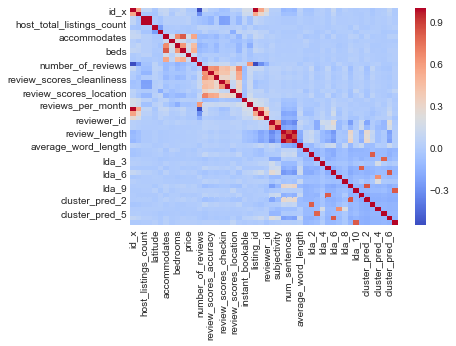

In [303]:
sns.heatmap(df3.corr(), cmap='coolwarm')

In [304]:
df3.columns

Index(['id_x', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'neighbourhood', 'zipcode', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'listing_id', 'id_y', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences',
       'comment_words_only', 'individual_words', 'word_count',
       'average_word_length', 'most_frequent_words', 'lda_1', 'lda_2', 'lda_3',
       'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'lda_10',
       'cluster_pred_1', 'cl

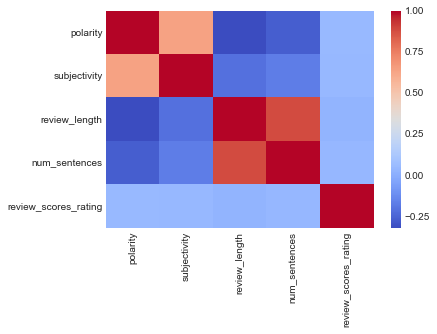

In [307]:
new = df3[['polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences','review_scores_rating']]
sns.heatmap(new.corr(), cmap='coolwarm')

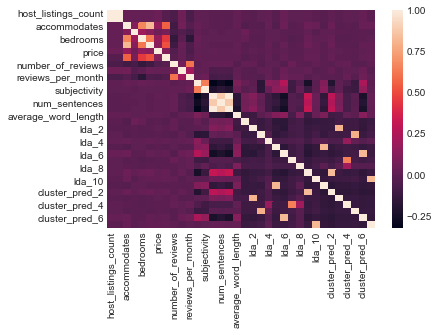

In [301]:
sns.heatmap(X.corr())

In [10]:
df3['property_type'].nunique()

29

In [13]:
df3.columns

Index(['id_x', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'neighbourhood', 'zipcode', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'listing_id', 'id_y', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences',
       'comment_words_only', 'individual_words', 'word_count',
       'average_word_length', 'most_frequent_words', 'lda_1', 'lda_2', 'lda_3',
       'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'lda_10',
       'cluster_pred_0', 'cl

In [14]:
X = df3[['polarity', 'subjectivity',
       'review_length', 'num_sentences', 'word_count',
       'average_word_length', 'lda_1',
       'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2', 'cluster_pred_3', 'cluster_pred_4',
       'cluster_pred_5', 'cluster_pred_6', 'cluster_pred_7']]

y = df3['review_scores_rating']

In [269]:
X = df3[['host_listings_count', 'host_total_listings_count',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews', 'instant_bookable',
        'reviews_per_month', 'polarity', 'subjectivity',
       'review_length', 'num_sentences',
       'word_count',
       'average_word_length', 'lda_1', 'lda_2', 'lda_3',
       'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'lda_10',
       'cluster_pred_1', 'cluster_pred_2', 'cluster_pred_3', 'cluster_pred_4',
       'cluster_pred_5', 'cluster_pred_6', 'cluster_pred_7']]

y = df3['price']

In [35]:
X = df3[['host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'polarity', 'subjectivity',
       'review_length', 'num_sentences', 'word_count',
       'average_word_length', 'lda_1', 'lda_2',
       'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2',
       'cluster_pred_3', 'cluster_pred_4', 'cluster_pred_5',
       'cluster_pred_6', 'cluster_pred_7', 'neighbourhood_Alameda',
       'neighbourhood_Arbor Lodge', 'neighbourhood_Argay',
       'neighbourhood_Arlington Heights', 'neighbourhood_Arnold Creek',
       'neighbourhood_Ashcreek', 'neighbourhood_Beaumont-Wilshire',
       'neighbourhood_Boise-Eliot', 'neighbourhood_Brentwood-Darlington',
       'neighbourhood_Bridgeton', 'neighbourhood_Bridlemile',
       'neighbourhood_Brooklyn', 'neighbourhood_Buckman',
       'neighbourhood_Cathedral Park', 'neighbourhood_Collins View',
       'neighbourhood_Concordia', 'neighbourhood_Creston-Kenilworth',
       'neighbourhood_Crestwood', 'neighbourhood_Cully',
       'neighbourhood_Downtown', 'neighbourhood_East Columbia',
       'neighbourhood_Eastmoreland', 'neighbourhood_Eliot',
       'neighbourhood_Far Southwest', 'neighbourhood_Forest Park',
       'neighbourhood_Foster-Powell', 'neighbourhood_Glenfair',
       'neighbourhood_Goose Hollow', 'neighbourhood_Grant Park',
       'neighbourhood_Hayden Island', 'neighbourhood_Hayhurst',
       'neighbourhood_Hazelwood', 'neighbourhood_Hillsdale',
       'neighbourhood_Hillside', 'neighbourhood_Hollywood',
       'neighbourhood_Homestead', 'neighbourhood_Hosford-Abernethy',
       'neighbourhood_Humboldt', 'neighbourhood_Irvington',
       'neighbourhood_Kenton', 'neighbourhood_Kerns',
       'neighbourhood_King', 'neighbourhood_Laurelhurst',
       'neighbourhood_Lents', 'neighbourhood_Lloyd District',
       'neighbourhood_Madison South', 'neighbourhood_Maplewood',
       'neighbourhood_Markham', 'neighbourhood_Marshall Park',
       'neighbourhood_Mill Park', 'neighbourhood_Montavilla',
       'neighbourhood_Mount Scott', 'neighbourhood_Mt. Tabor',
       'neighbourhood_Multnomah', 'neighbourhood_N. Tabor',
       'neighbourhood_Northwest District',
       'neighbourhood_Old Town/Chinatown', 'neighbourhood_Overlook',
       'neighbourhood_Parkrose', 'neighbourhood_Parkrose Heights',
       'neighbourhood_Pearl', 'neighbourhood_Piedmont',
       'neighbourhood_Pleasant Valley', 'neighbourhood_Portsmouth',
       'neighbourhood_Powellhurst-Gilbert', 'neighbourhood_Reed',
       'neighbourhood_Richmond', 'neighbourhood_Rose City Park',
       'neighbourhood_Roseway', 'neighbourhood_Russell',
       'neighbourhood_Sabin', 'neighbourhood_Sellwood-Moreland',
       'neighbourhood_South Burlingame', 'neighbourhood_South Portland',
       'neighbourhood_South Tabor', 'neighbourhood_Southwest Hills',
       'neighbourhood_St. Johns', "neighbourhood_Sullivan's Gulch",
       'neighbourhood_Sumner', 'neighbourhood_Sunderland',
       'neighbourhood_Sunnyside', 'neighbourhood_Sylvan-Highlands',
       'neighbourhood_University Park', 'neighbourhood_Vernon',
       'neighbourhood_West Portland Park', 'neighbourhood_Wilkes',
       'neighbourhood_Woodland Park', 'neighbourhood_Woodlawn',
       'neighbourhood_Woodstock', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Dome house',
       'property_type_Earth house', 'property_type_Farm stay',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House',
       'property_type_Houseboat', 'property_type_Hut',
       'property_type_In-law', 'property_type_Loft',
       'property_type_Other', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
        'amenities_gym', 'amenities_kitchen', 'amenities_pets_allowed',
       'amenities_hot_tub', 'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub']]

y=df3['price']

#### Train-test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)
est = lr.predict(X_test)

ValueError: could not convert string to float: '{Wifi,"Free street parking",Heating,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Self check-in",Lockbox,"Room-darkening shades","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Single level home","BBQ grill","Garden or backyard","Luggage dropoff allowed"}'

In [41]:
print('Train R^2: ',est.score(X_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, est.predict(X_test)))
print('\n')

AttributeError: 'numpy.ndarray' object has no attribute 'score'

In [ ]:
est = LinearRegression()

In [42]:
est = LinearRegression()

est.fit(X_train, y_train)
print('Train R^2: ',est.score(X_test, y_test))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('\n')

Train R^2:  0.04528524538181633
Train SSE: 6.069985057336242




In [241]:
X_train_2 = X_train['polarity']

In [276]:
est.predict(X_test).mean()

97.20041780836185

In [41]:
from sklearn import metrics

In [280]:
print(f'MAE: {metrics.mean_absolute_error(y_test, est.predict(X_test))}')
print(f'MSE: {metrics.mean_squared_error(y_test, est.predict(X_test))}')

MAE: 1.7037470389656493
MSE: 5.796081148970666


In [283]:
with open('backups/X_train.pickle', 'wb') as p:
    pickle.dump(X_train, p)
    
with open('backups/y_train.pickle', 'wb') as p:
    pickle.dump(y_train, p)
    
with open('backups/df3', 'wb') as p:
    pickle.dump(df3, p)

In [43]:
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_train, y_train)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [44]:
pred = est.predict(X_test)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [45]:
print('Train R^2: ',est.score(X_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, est.predict(X_test)))
print('\n')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train R^2:  0.046436573184035046
Train SSE: 6.07014046035946
Test R^2:  0.04527630046334152
Test SSE: 6.030372624926767




In [46]:
pred

array([97.56934545, 96.67090795, 97.11451147, ..., 97.52295873,
       97.07276342, 96.75879858])

In [47]:
y_train

174924     98.0
110176     99.0
282007     91.0
205220     99.0
73280      97.0
22379      97.0
163828     98.0
208191    100.0
188573     99.0
85316      96.0
138272     92.0
30162      95.0
190185     99.0
63215      92.0
47050      97.0
          ...  
68852      98.0
43624      98.0
288672     99.0
198674     98.0
182223     82.0
92230      97.0
143296     99.0
58655      99.0
216254     93.0
115457     98.0
125295     99.0
268936     99.0
137663     99.0
153001     99.0
127494     96.0
Name: review_scores_rating, Length: 204734, dtype: float64

In [50]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtrain,ytrain),model.score(xtest, ytest)


def quick_test_a_few_times(model, X, y, n=10):
    return (pd.DataFrame([quick_test(model, X, y) for j in range(n)],
                         columns=['Train Acc','Test Acc'])).mean()

# new_model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
# # pred = new_model.predict(X_test)
# # Do the test 10 times with a LinearSVC and get the average score
# print(quick_test_a_few_times(new_model, X_train, y_train))

In [55]:
def get_scores(model):
    mod = model
    mod = mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'Train accuracy: {mod.score(X_train, y_train)}')
    print(f'Test accuracy: {mod.score(X_test, y_test)}')
    print(f'Precision: {precision_score(y_test, predictions)}')
    print(f'Recall: {recall_score(y_test, predictions)}')
    print('\n')
    print(classification_report(y_test, predictions))

In [42]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
get_scores(model)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 1.0
Test accuracy: -0.1368617688030913


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [63]:
model = make_pipeline(StandardScaler(), GradientBoostingRegressor())
model.fit(X_train, y_train)
pred = model.predict(X_test)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [ ]:
import pprint
pprint.pprint(list_of_coeffs)

In [ ]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

In [ ]:
s2 = LinearSVC()
s2.fit(X_train, y_train)
s2.coef_ # the absolute value dictates importance

In [71]:
    predictions = model.predict(X_test)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'Train accuracy: {model.score(X_train, y_train)}')
    print(f'Test accuracy: {model.score(X_test, y_test)}')
    print('\n')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 0.13410469226577104


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Test accuracy: 0.12584934455459584




In [ ]:
model = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
model.fit(X_train, y_train)
# pred = model.predict(X_test)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


In [37]:
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [38]:
    print(f'Train accuracy: {model.score(X_train, y_train)}')
    print(f'Test accuracy: {model.score(X_test, y_test)}')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 0.09727831023431334
Test accuracy: 0.09714727252628486


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [43]:
model = make_pipeline(StandardScaler(), GradientBoostingRegressor())
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train)}')
print(f'Test accuracy: {model.score(X_test, y_test)}')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 0.9714657875667823


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Test accuracy: 0.9775711429687329


Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews',
       ...
       'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub'],
      dtype='object', length=183)

(array([   80.,   522.,   270.,  3830.,  5818., 12721., 25271., 19674.,
        35074., 30621., 28137., 28030., 26899., 16171.,  8644., 14478.,
        11340.,  3217.,  7992.,  1975.,  2329.,  3437.,  1825.,  1617.,
         4292.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200.]),
 <a list of 25 Patch objects>)

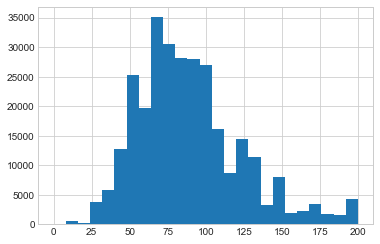

In [55]:
plt.hist(df3['price'], range=(0,200), bins=25)

(array([1.2500e+02, 3.7000e+02, 2.8300e+02, 1.5500e+02, 7.6000e+01,
        3.9400e+02, 2.6500e+02, 3.2100e+02, 7.6300e+02, 1.1850e+03,
        2.5800e+03, 3.0110e+03, 5.6780e+03, 6.5370e+03, 1.3945e+04,
        1.7967e+04, 3.1370e+04, 4.8582e+04, 6.6245e+04, 1.0553e+05]),
 array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.]),
 <a list of 20 Patch objects>)

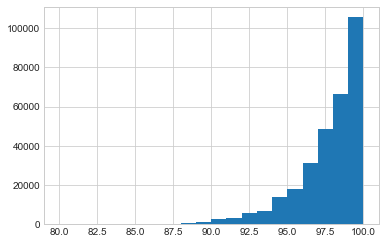

In [57]:
plt.hist(df3['review_scores_rating'], range=(80,100), bins=20)

In [62]:
model.steps[1][1]

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
sorted(list(zip(model.steps[1][1].feature_importances_, X.columns)), reverse=True)

[(0.44109506688092603, 'latitude'),
 (0.17532148162784578, 'room_type_Entire home/apt'),
 (0.12516394286589846, 'number_of_reviews'),
 (0.07663280753128292, 'property_type_Loft'),
 (0.06310344104832985, 'neighbourhood_Richmond'),
 (0.04937136131897647, 'longitude'),
 (0.030191212511981844, 'bedrooms'),
 (0.015337912249981989, 'room_type_Private room'),
 (0.006059423132137886, 'bathrooms'),
 (0.005673982870587622, 'accommodates'),
 (0.0024059130408432454, 'neighbourhood_Old Town/Chinatown'),
 (0.0015516446640827966, 'reviews_per_month'),
 (0.0013452466350622032, 'guests_included'),
 (0.0012243630063106345, 'host_total_listings_count'),
 (0.0009186008397789174, 'neighbourhood_Northwest District'),
 (0.0008285952876562317, 'review_scores_rating'),
 (0.000782728586903674, 'beds'),
 (0.000564072165413471, 'neighbourhood_Pearl'),
 (0.0005025748542529757, 'host_listings_count'),
 (0.000308109109484551, 'neighbourhood_Southwest Hills'),
 (0.000251735527099812, 'review_scores_cleanliness'),
 (0